# Chapter 7 
 Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Computer Experiments

In [2]:
import random
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import mistat
from statsmodels.nonparametric.smoothers_lowess import lowess
from itertools import chain
from doepy.build import lhs

## Introduction to Computer Experiments

## Designing Computer Experiments

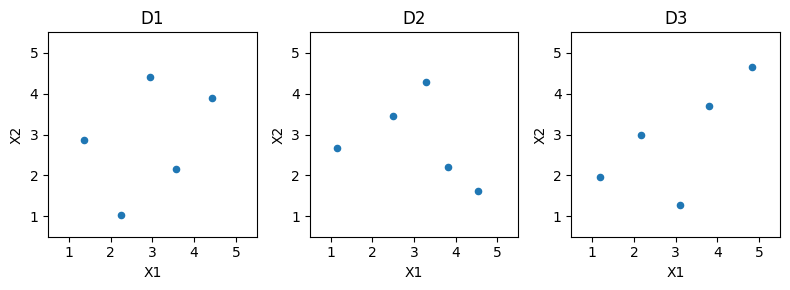

In [3]:
from doepy.build import lhs, space_filling_lhs
np.random.seed(2)

Factors = {
    'X1': [1, 5],
    'X2': [1, 5],
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
lim = [0.5, 5.5]
for idx, ax in enumerate(axes, 1):
  if idx == 0:
    Design = space_filling_lhs(Factors, num_samples=5)
  else:
    Design = lhs(Factors, num_samples=5)

  Design.plot.scatter(x='X1', y='X2', ax=ax)
  ax.set_xlim(lim)
  ax.set_ylim(lim)
  ax.set_title(f'D{idx}')

plt.tight_layout()
plt.show()

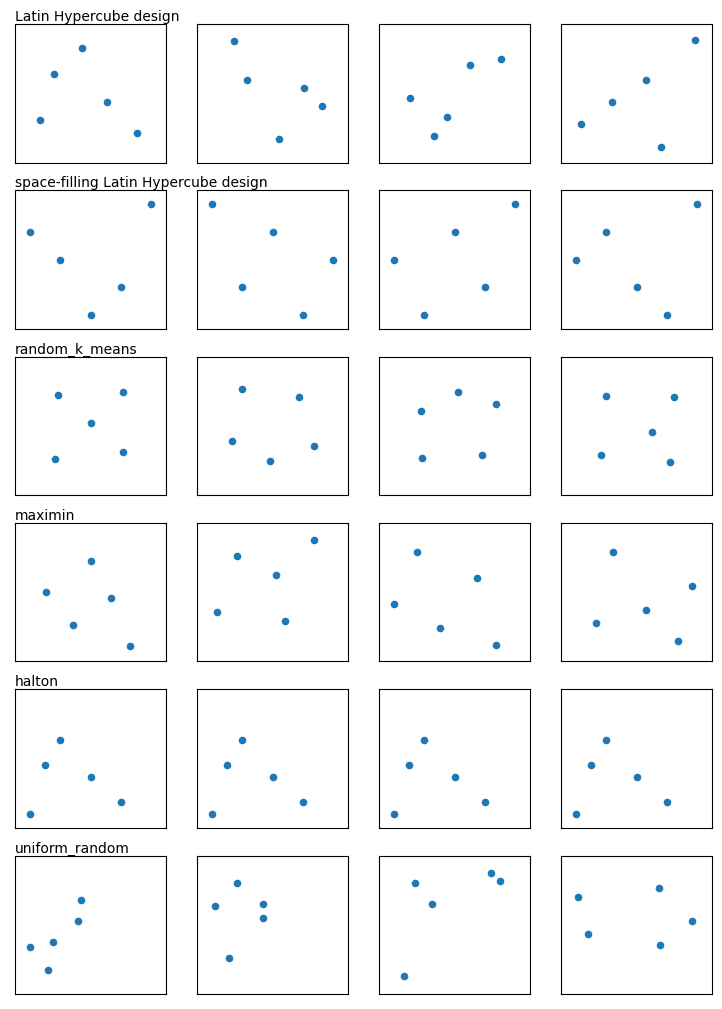

In [4]:
# various approaches to create Latin hypercube designs
# Various methods
from doepy import build
designMethods = [
    ('Latin Hypercube design', build.lhs),
    ('space-filling Latin Hypercube design', build.space_filling_lhs),
    ('random_k_means', build.random_k_means),
    ('maximin', build.maximin),
    ('halton', build.halton),
    ('uniform_random', build.uniform_random)
]

num_samples = 5
fig, axes = plt.subplots(nrows=len(designMethods), ncols=4, figsize=(9, 2.1 * len(designMethods)))
for nmethod, (label, builder) in enumerate(designMethods):
    np.random.seed(1)
    for idx in range(len(axes[0])):
        Design = builder(Factors, num_samples=num_samples)
        ax = axes[nmethod][idx]
        Design.plot.scatter(x='X1', y='X2', ax=ax)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
    ax = axes[nmethod][0]

for nmethod, (label, _) in enumerate(designMethods):
    ax = axes[nmethod][0]
    pos = ax.get_position()
    plt.text(pos.x0, pos.y1, label, transform=fig.transFigure, verticalalignment='bottom')

# plt.tight_layout()
plt.show()

In [5]:
from doepy.build import lhs
np.random.seed(1)
Factors = {
    'm': [30, 60],
    's': [0.005, 0.02],
    'v0': [0.002, 0.01],
    'k': [1_000, 5_000],
    'p0': [90_000, 110_000],
    't': [290, 296],
    't0': [340, 360],
}
Design = lhs(Factors, num_samples=14)

# Randomize and create replicates
nrepeat = 50
Design = Design.sample(frac=1).reset_index(drop=True)
Design = Design.loc[Design.index.repeat(nrepeat)].reset_index(drop=True)

kwargs = {c: list(Design[c]) for c in Design.columns}
simulator = mistat.PistonSimulator(**kwargs)
result = simulator.simulate()
result = mistat.simulationGroup(result, nrepeat)

mean_result = result.groupby('group').mean()

In [6]:
style = mean_result.style
style = style.format(subset=['k', 'p0'], precision=0)
style = style.format(subset=['m', 't0'], precision=1)
style = style.format(subset=['t'], precision=2)
style = style.format(subset=['seconds'], precision=3)
style = style.format(subset=['s'], precision=4)
style = style.format(subset=['v0'], precision=5)
print(style.to_latex(hrules=True))

\begin{tabular}{lrrrrrrrr}
\toprule
 & m & s & v0 & k & p0 & t & t0 & seconds \\
group &  &  &  &  &  &  &  &  \\
\midrule
1 & 43.5 & 0.0137 & 0.00691 & 4831 & 92407 & 291.32 & 346.7 & 0.054 \\
2 & 45.3 & 0.0065 & 0.00338 & 1731 & 108910 & 292.57 & 344.0 & 0.037 \\
3 & 53.4 & 0.0058 & 0.00910 & 1405 & 95564 & 294.36 & 352.4 & 0.165 \\
4 & 38.5 & 0.0123 & 0.00639 & 2842 & 99869 & 293.21 & 353.7 & 0.048 \\
5 & 59.9 & 0.0176 & 0.00288 & 2263 & 108091 & 291.94 & 350.1 & 0.015 \\
6 & 30.9 & 0.0111 & 0.00745 & 3060 & 93058 & 290.04 & 359.4 & 0.066 \\
7 & 50.2 & 0.0188 & 0.00411 & 1086 & 97083 & 295.04 & 356.2 & 0.020 \\
8 & 41.4 & 0.0102 & 0.00976 & 3486 & 90210 & 290.94 & 357.3 & 0.110 \\
9 & 48.4 & 0.0079 & 0.00533 & 4088 & 101575 & 292.70 & 340.3 & 0.073 \\
10 & 38.9 & 0.0125 & 0.00549 & 4704 & 98214 & 293.61 & 342.7 & 0.044 \\
11 & 56.3 & 0.0086 & 0.00870 & 2108 & 104854 & 295.96 & 349.0 & 0.108 \\
12 & 54.3 & 0.0194 & 0.00200 & 2434 & 100379 & 290.52 & 355.6 & 0.009 \\
13 & 34.3 & 0.014

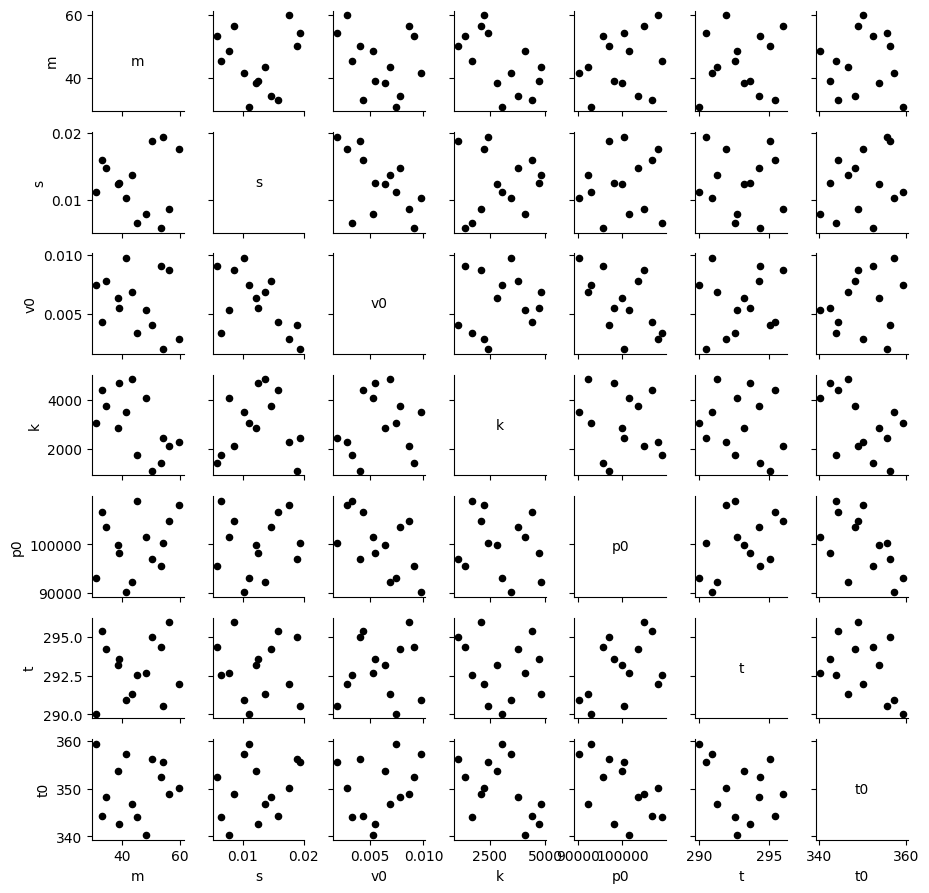

In [7]:
np.random.seed(1)
Design = lhs(Factors, num_samples=14)

def panelPlot(x, y, **kwargs):
    plt.scatter(x, y, **kwargs,
                facecolors='black', edgecolor='black', s=20)
    dx = 0.05*(max(x) - min(x))
    plt.xlim(min(x)-dx, max(x) + dx)
    dy = 0.05*(max(y) - min(y))
    plt.ylim(min(y)-dy, max(y) + dy)

g = sns.PairGrid(Design, height=1.3)
g = g.map_offdiag(panelPlot)
for idx, column in enumerate(Factors):
    ax = g.axes[idx][idx]
    ax.text(0.5, 0.5, column, transform=ax.transAxes,
            verticalalignment='center', horizontalalignment='center')

## Analyzing Computer Experiments

In [8]:
from pyKriging.krige import kriging
random.seed(1)

outcome = 'seconds'
predictors = ['m', 's', 'v0', 'k', 'p0', 't', 't0']

model = kriging(mean_result[predictors].values, mean_result[outcome].values)
model.train()

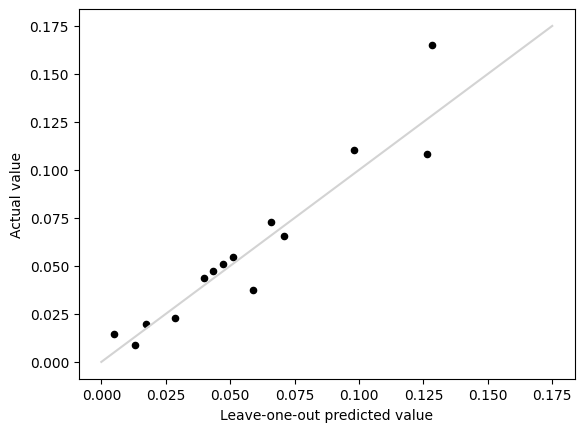

In [9]:
# use precalculated values to skip jackknife
validation = pd.DataFrame({'actual': {0: 0.05441877891968666,
  1: 0.03727837011155499,
  2: 0.1651319040375938,
  3: 0.047593258114843086,
  4: 0.01456573521939926,
  5: 0.0655038377359666,
  6: 0.019871385950919314,
  7: 0.11022122791225683,
  8: 0.07294231445090985,
  9: 0.04356622464674687,
  10: 0.10830895867381393,
  11: 0.009048596833718543,
  12: 0.05076351774449578,
  13: 0.02298875168903235},
 'predicted': {0: 0.05095935548701239,
  1: 0.058740234719276106,
  2: 0.1284175012474648,
  3: 0.043225924165150004,
  4: 0.004876412005997776,
  5: 0.07103701426464179,
  6: 0.017284071531404925,
  7: 0.09788530171452367,
  8: 0.06587533561671288,
  9: 0.03994568846369216,
  10: 0.12620555835653657,
  11: 0.012938892361934535,
  12: 0.04721028883379725,
  13: 0.028418579391554052}})
ax = validation.plot.scatter(x='predicted', y='actual', color='black')
ax.plot([0, 0.175], [0, 0.175], color='lightgrey')
ax.set_xlabel('Leave-one-out predicted value')
ax.set_ylabel('Actual value')
plt.show()

In [10]:
def looValidation(data, seed=123):
    random.seed(seed)
    jackknife  = []
    for i, row in data.iterrows():
        subset = data.drop(i)
        model = kriging(subset[predictors].values, subset[outcome].values)
        model.train()
        jackknife.append({
            'actual': row[outcome],
            'predicted': model.predict(row[predictors].values),
        })
    return pd.DataFrame(jackknife)
validation = looValidation(mean_result)

In [11]:
from sklearn import metrics
MAE = metrics.mean_absolute_error(validation['actual'], validation['predicted'])
R2 = metrics.r2_score(validation['actual'], validation['predicted'])
print(f'MAE = {MAE:.4f}')
print(f'r2 {R2:.3f}', )

MAE = 0.0091
r2 0.897


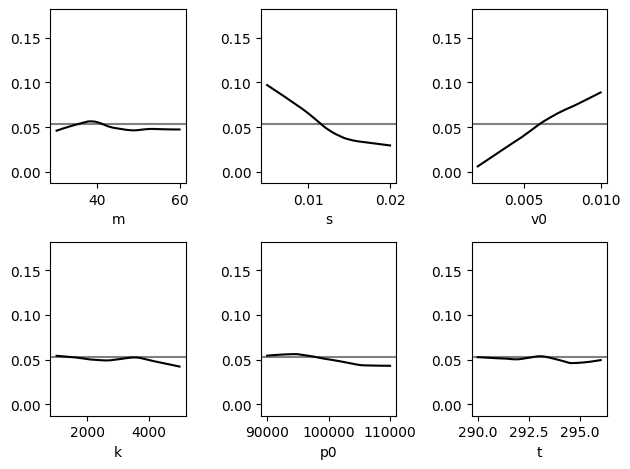

In [12]:
random.seed(1)
# create a large latin hypercube design
Design = lhs(Factors, num_samples=500)

# for each row in the design, predict the cycle time using the kriging model
predictions = []
for _, row in Design.iterrows():
    predictions.append(model.predict(row[predictors].values))
Design['seconds'] = predictions

# determine and plot the marginal distribution using lowess regression
fig, axes = plt.subplots(ncols=3, nrows=2)
ylim = (min(Design['seconds']),max(Design['seconds']))
for ax, column in zip(chain.from_iterable(axes), predictors):
    fit = lowess(Design['seconds'], Design[column],
                 frac=0.5, it=1, return_sorted=True)
    fit = pd.DataFrame(fit, columns=['x', 'y'])
    ax.axhline(Design['seconds'].mean(), color='grey')
    ax.plot(fit['x'], fit['y'], color='black')
    ax.set_ylim(ylim)
    ax.set_xlabel(column)
plt.tight_layout()

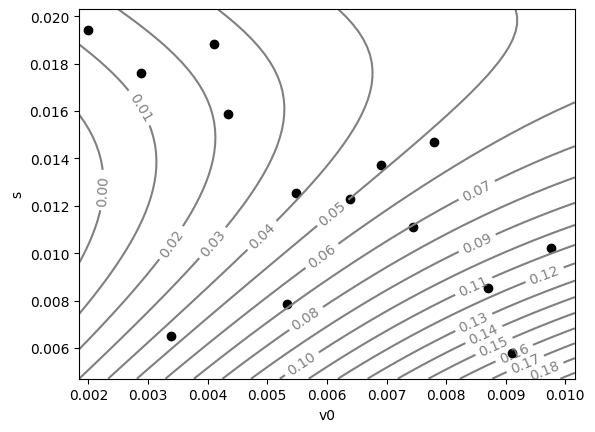

In [13]:
def plotSurface(model, data, f1, f2, ncontours=20):
    def linspace(limits):
        lmin, lmax = limits
        padding = 0.02 * (lmax - lmin)
        return np.linspace(lmin-padding, lmax+padding)
    x1 = linspace(Factors[f1])
    x2 = linspace(Factors[f2])
    X1, X2 = np.meshgrid(x1, x2)

    grid = {f1: X1.ravel(), f2: X2.ravel()}
    for f in predictors:
        if f in (f1, f2):
            continue
        grid[f] = np.mean(Factors[f])
    df = pd.DataFrame(grid)
    responses = np.array([model.predict(v.values) for _, v in df[predictors].iterrows()])

    # display in factor co-ordinates
    svalues = x1
    kvalues = x2
    CS = plt.contour(svalues, kvalues,
                responses.reshape(len(x2), len(x1)),
                ncontours, colors='gray')
    ax = plt.gca()
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.scatter(data['v0'], data['s'], color='black')
    return ax

ax = plotSurface(model, mean_result, 'v0', 's')
plt.show()

## Stochastic Emulators

## Integrating Physical and Computer Experiments

## Simulation of Random Variables

### Basic Procedures

### Generating Random Vectors

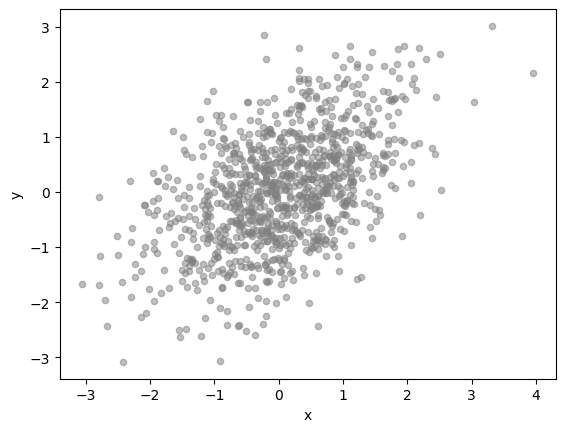

In [14]:
np.random.seed(1)

def standardBivariateNorm(rho, Ns):
  X = stats.norm.rvs(size=Ns)
  Y = rho*X + np.sqrt(1-rho**2)*stats.norm.rvs(size=Ns)
  return pd.DataFrame({'x': X, 'y': Y})

standardBivariateNorm(0.5, 1000).plot.scatter('x', 'y', alpha=0.5, color='gray')
plt.show()

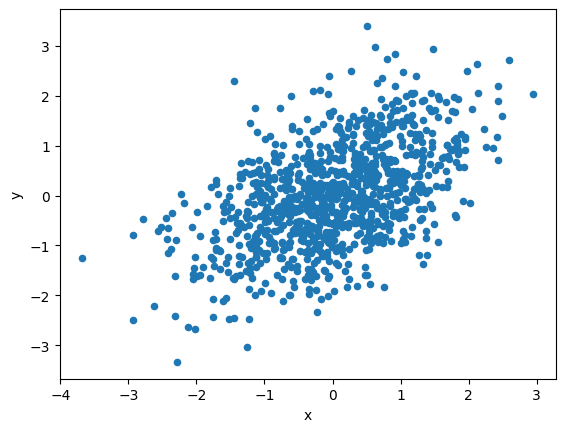

In [15]:
rv = stats.multivariate_normal.rvs(mean=(0, 0), cov=[[1, 0.5], [0.5, 1]],
                                   size=1000)
pd.DataFrame(rv, columns=('x', 'y')).plot.scatter('x', 'y')
plt.show()

### Approximating Integrals

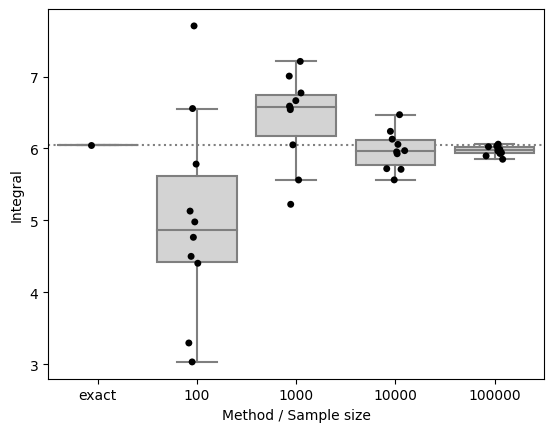

In [16]:
np.random.seed(2)

rho = 0.8
exact = np.exp(1 + rho)
integrals = [{'Method': 'exact', 'Integral': exact}]

# simulate
for Ns in (100, 1000, 10_000, 100_000):
  for _ in range(10):
    rv = standardBivariateNorm(rho, Ns)
    integrals.append({
      'Method': str(Ns),
      'Integral': np.mean(np.exp(rv['x'] + rv['y'])),
    })
df = pd.DataFrame(integrals)
ax = sns.boxplot(x=df['Method'], y=df['Integral'], color='lightgrey', fliersize=0)
ax = sns.stripplot(x=df['Method'], y=df['Integral'], color='black', ax=ax)
ax.axhline(exact, linestyle=':', color='grey', zorder=0)
ax.set_xlabel('Method / Sample size')
plt.show()

## Chapter Highlights

## Exercises